# Style Transfer

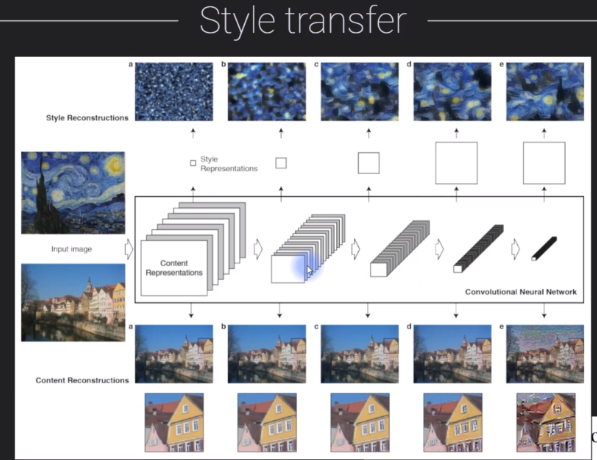

High Level Overview:
- Say we have two images - content image (bottom image) and style image (top image)
- We pass it through a pre-trained CNN (say VGG). (We don't train the CNN). We just want to compute the feature maps
- Feature maps give the details of content image.
- To extract the styles, we use a transformation called __Gram Matrix__.
- We extract pixel data from content image, and style data using gram matrix from style image.
- We combine two streams together, and produce a resultant op like below:

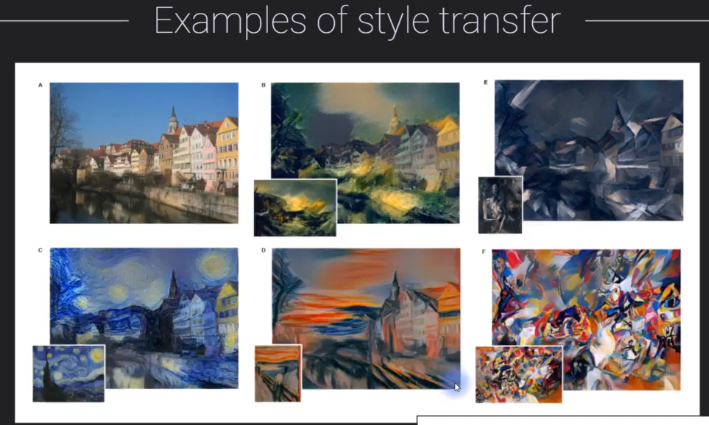

# Gram Matrix (Feature Activation Covariance)

## Covariance Matrix

__Correlation matrix__ - contains correlations of each pair of data in a matrix. Diagonals are 1, and matrix is symmetric

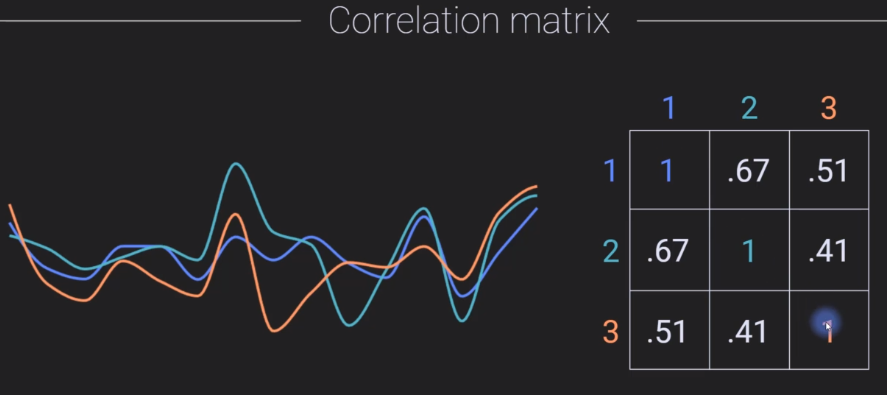

Correlation matrix values are normalized to a maximum possible value of 1.  
__Covariance matrix__ is a correlation matrix which is not normalized. Diagonals are variances of each feature/variable.

It contains all pairwise linear interactions across all of features

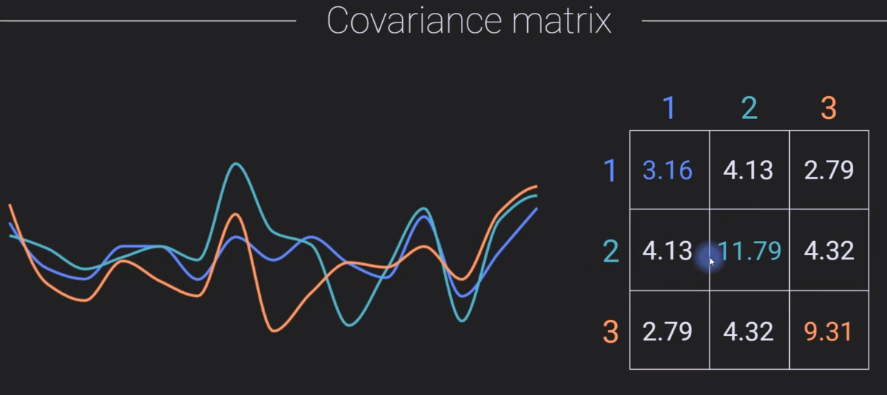

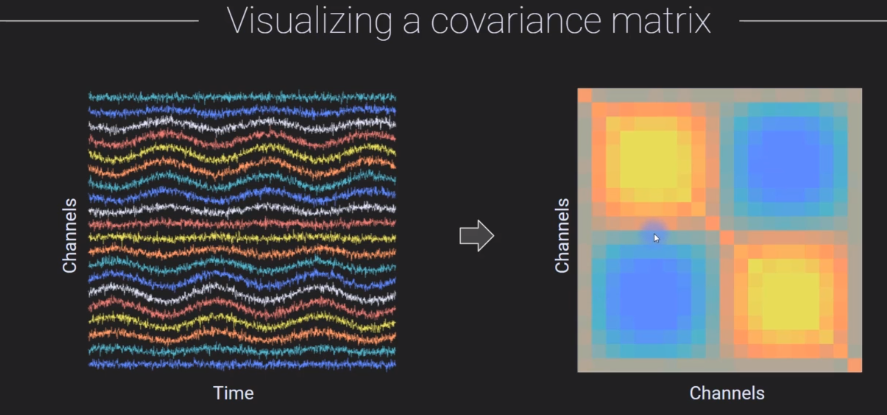

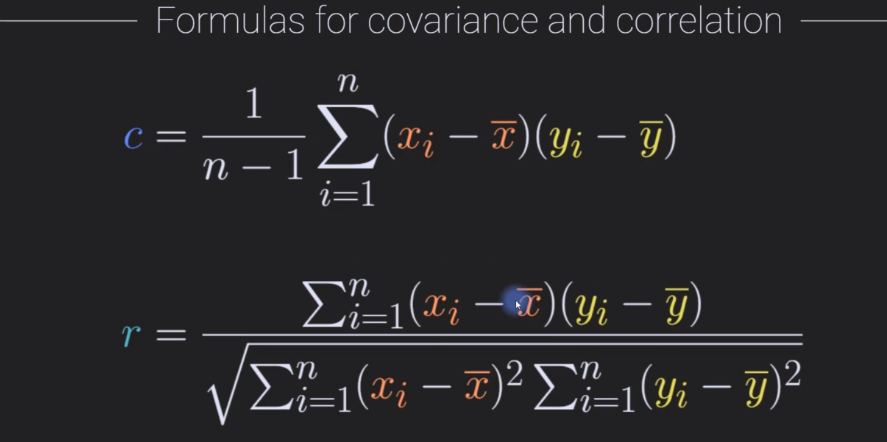

Covariance can be interpreted as a dot product

$$ C = \frac{1}{n-1}X^TX$$

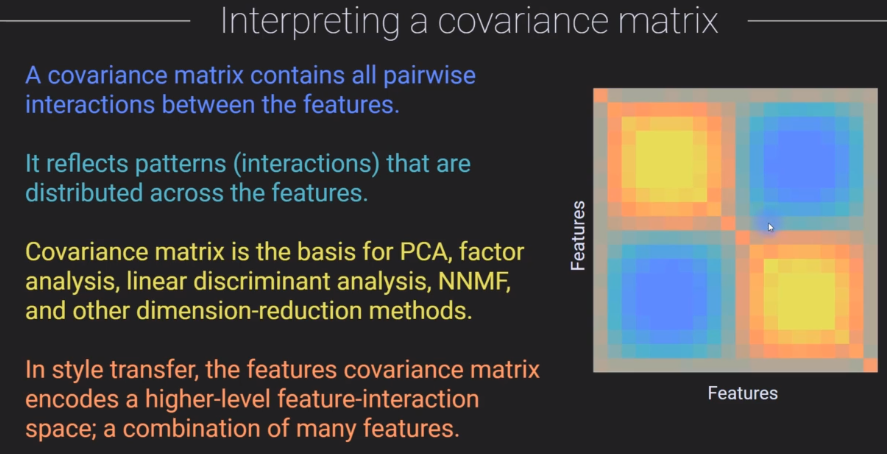

# Gram Matrix

ALmost same as Covariance matrix. Difference is that Covariance matrix is mean-centered, where every data value is mean value subtracted, whereas Gram Matrix has no such thing.

__Gram Matrix is computed from a feature map (Output of the convolution layer). Each channel is treated as $X$__

It is common to scale grame matrix by N to Normalize across feature maps

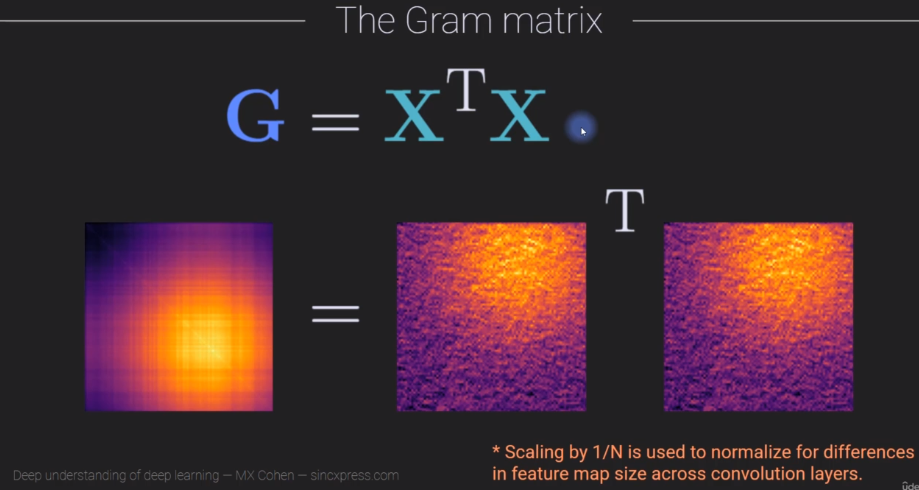

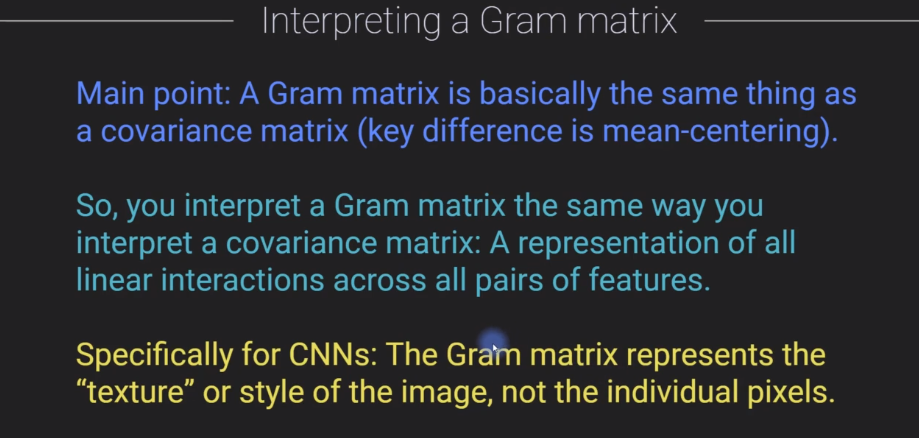

As Gram matrix is computed on a feature map which itself is computed on a part of image (bunch of pixels), it represents the style or texure of image, not just individual pixels.

To compute Gram Matrix for a feature cube (with multiple feature channels), we flatten the feature cube to a 2D map and compute on it.

Number of rows of flattened matrix = number of channels/kernels learned

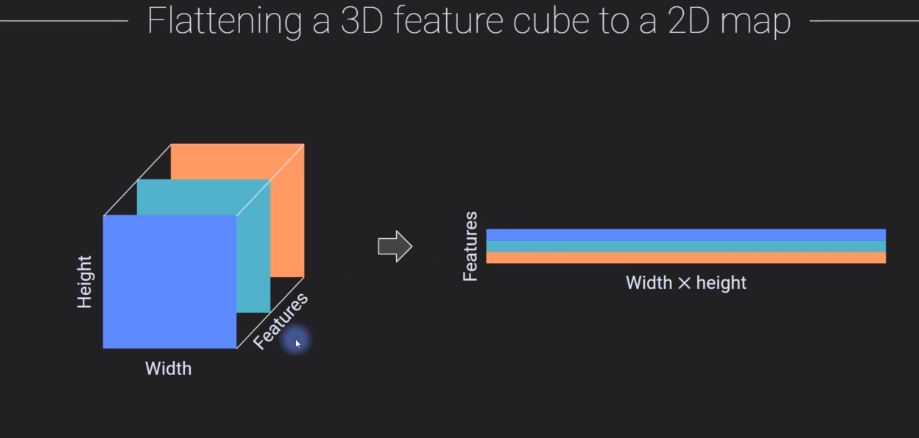

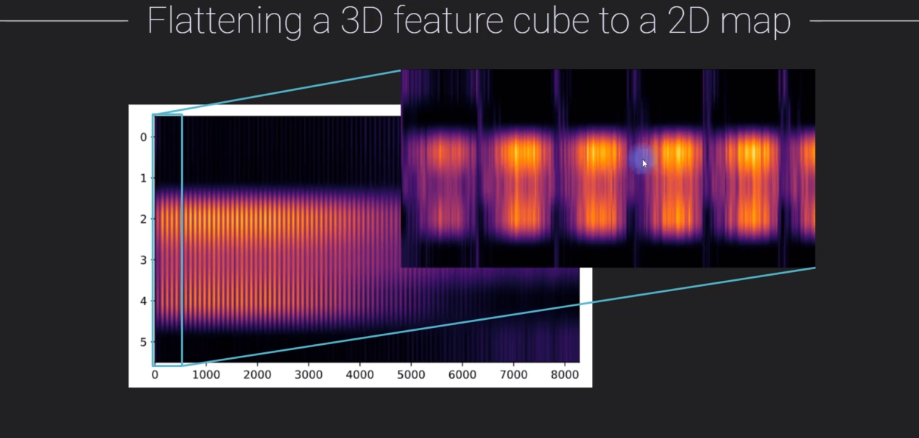

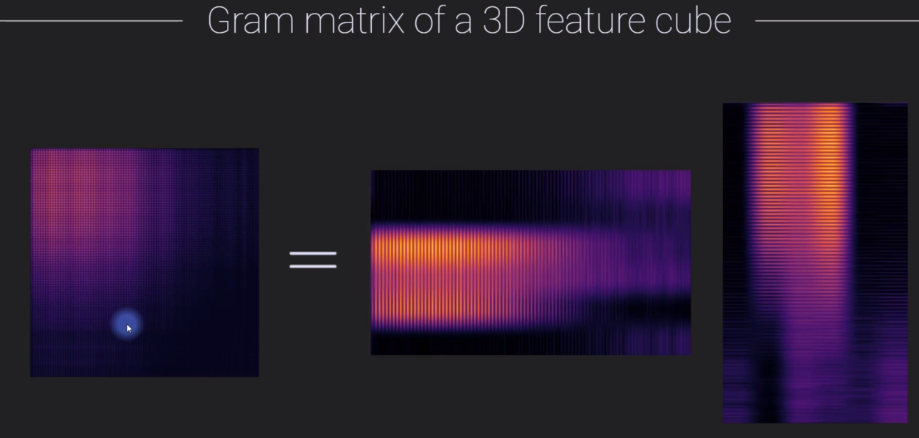

# Style transfer Algorithm

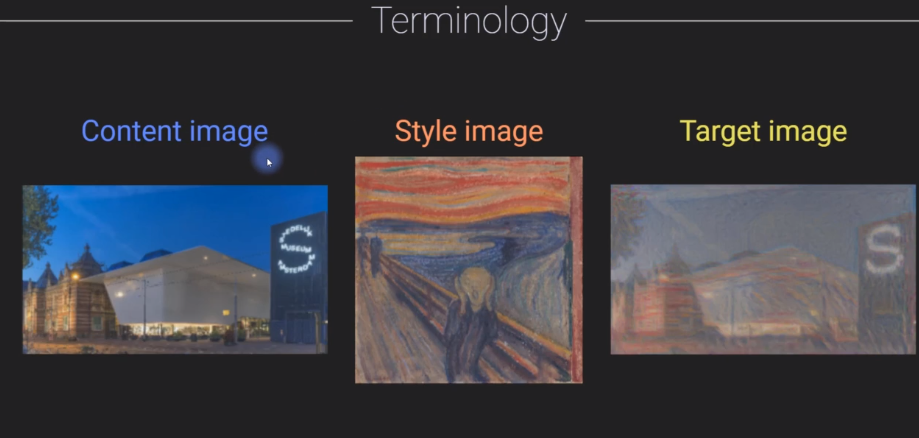

Step 1 - Create target image as random numbers to make it trainable

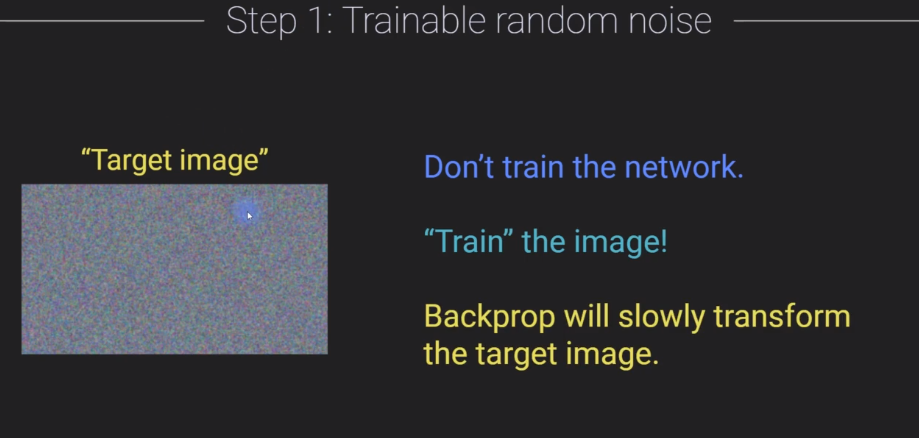

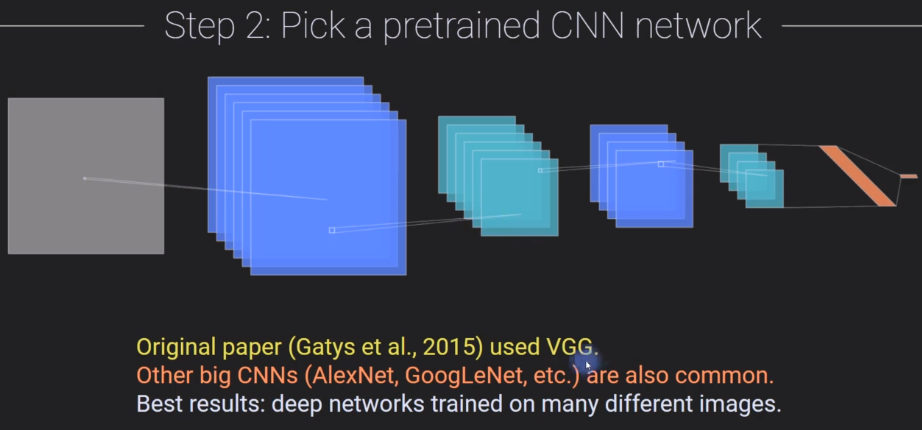

Step 3 - Train net to match pixel level features from target image to look more like content image. Loss function is MSE. Over training, target image will start to look more and more like content image.
Goal is to make target image look like content image as early as possible, i.e. in the first few convolution layers itself, as later layers will contain more abstract representations of original image.

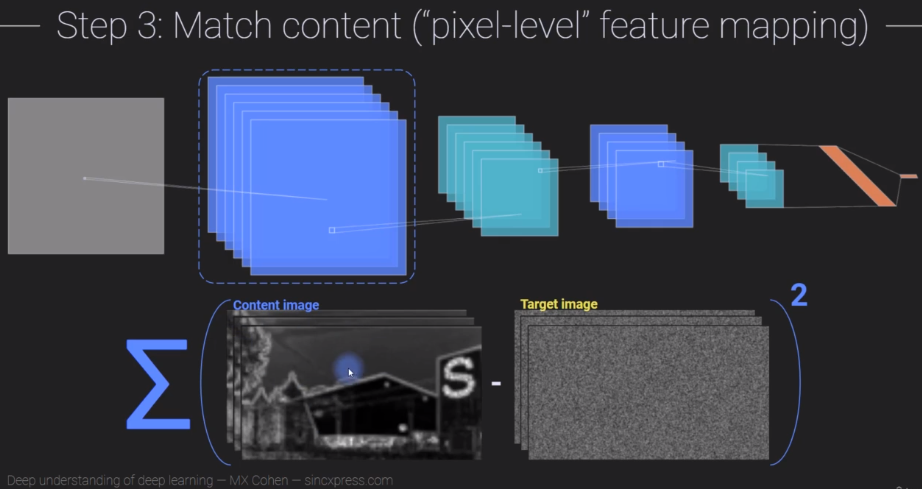

Step 4 - Match the style.
We do step 3 by using style image instead of content image. However, we do not care about matching feature maps here, __we are interested in matching the gram matrices__. Loss is still MSE

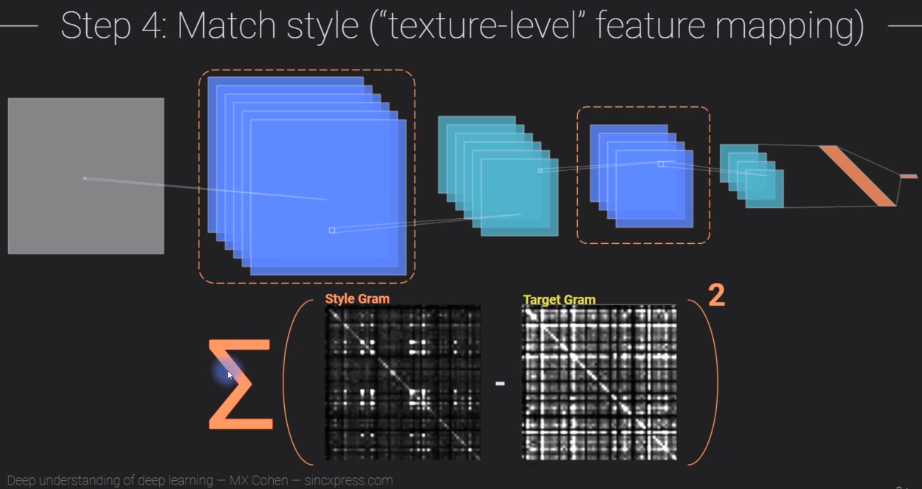

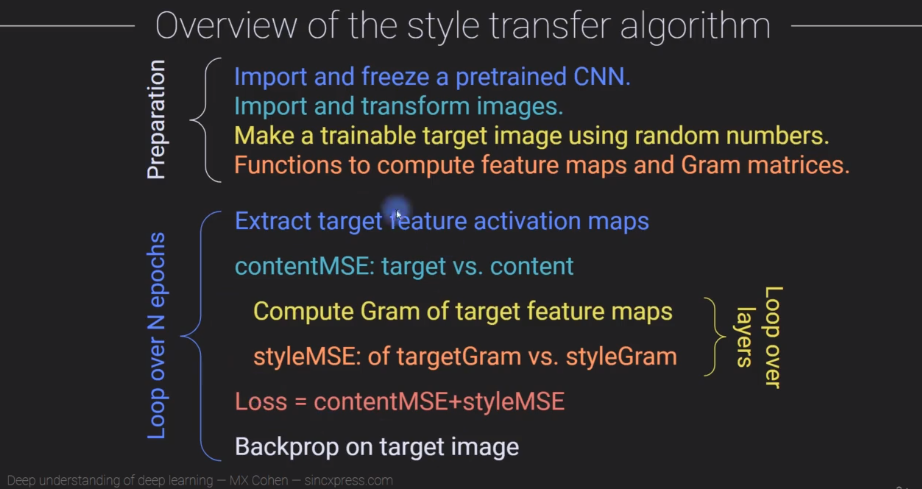

__We need to have target image as trainable, i.e., a pytorch object with requires_grad as True__

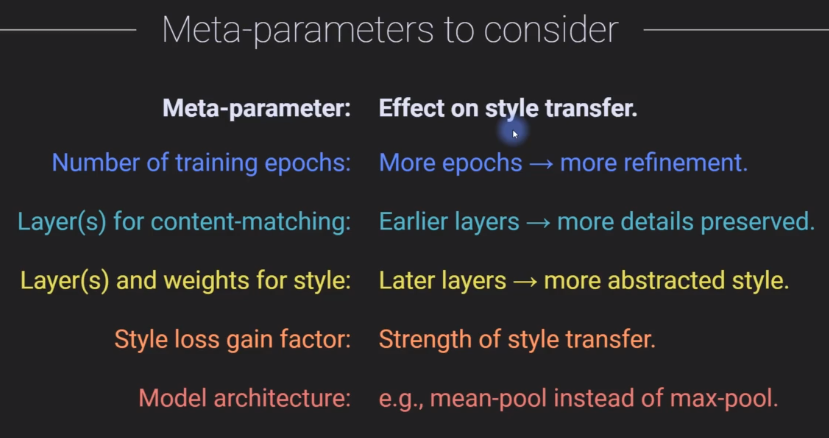

__We can decide which convolution layers we want to push the style image through, and also assign importance (weights) to the layers that we want to prioritize.__

# Style transfer on Screaming Bathtub

In [5]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

import warnings; warnings.filterwarnings('ignore')

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [6]:
# import the model
vgg19 = torchvision.models.vgg19(pretrained=True)

# freeze all layers
for p in vgg19.parameters():
    p.requires_grad = False
    
# set to evaluation mode
vgg19.eval();

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg19.to(device);

## Importing two images

In [8]:
img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img4style   = imread('https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [9]:
## These images are really large, which will make training take a long time. 

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


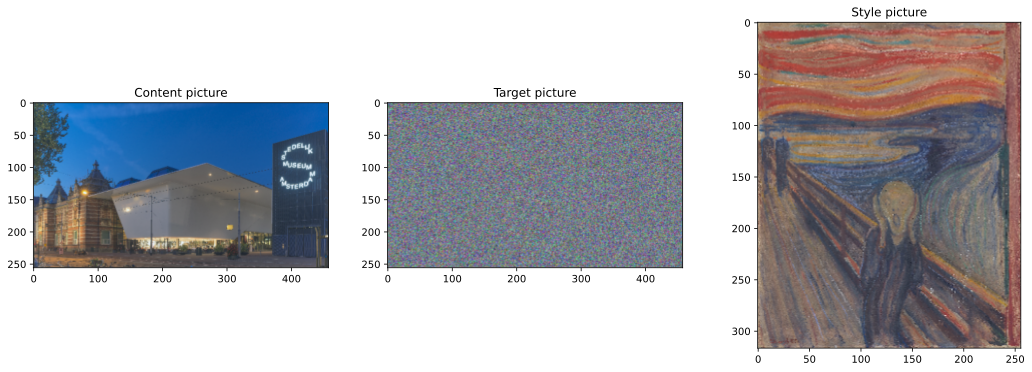

In [10]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

## Functions to extract image feature map activations

In [11]:
# function returning feature map for an input image

def getFeatureMap(img, net):
    
    fmap = []
    fname = []
    
    convLayeridx = 0 # layer after which feature map is required
    
    # looping through all layers in 'features' block
    for lnum in range(len(net.features)):
        
        # processing img through the layer 
        img = net.features[lnum](img)
        
        # store image if its a conv2d layer
        if 'Conv2d' in str(net.features[lnum]):
            fmap.append(img)
            fname.append('ConvLayer_'+str(convLayeridx))
            convLayeridx += 1
            
    return fmap, fname

In [12]:
# function to return gram matrix of a feature activation map

def gram_matrix(M):
    # reshape to 2D
    _, chans, height, width = M.shape
    M = M.reshape(chans,height*width)
    
    gram = torch.mm(M,M.t())/(chans*height*width)
    
    return gram

In [13]:
# inspect the output of the function
featmaps,featnames = getFeatureMap(img4content,vgg19)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 458])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 458])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 229])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 229])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_15" is size torch

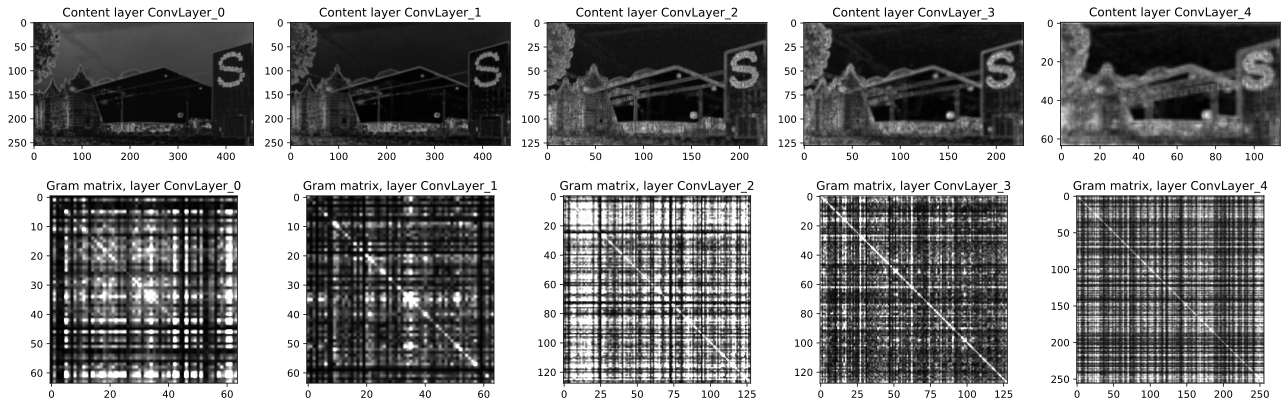

In [14]:
# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMap(img4content,vgg19)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0,i].imshow(pic,cmap='gray')
    axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


    ### now show the gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1,i].imshow(pic,cmap='gray',vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

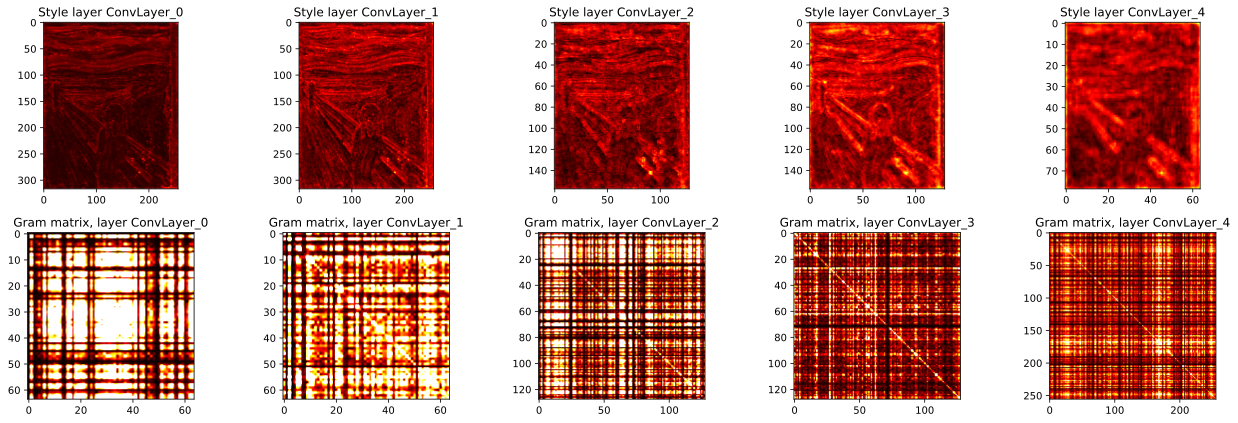

In [15]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMap(img4style,vgg19)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

    # average over all feature maps from this layer, and normalize
    pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0,i].imshow(pic,cmap='hot')
    axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


    ### now show the gram matrix
    pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1,i].imshow(pic,cmap='hot',vmax=.1)
    axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

## Transfer Process

In [16]:
# which layers to use

layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      1       ,     .5      ,     .5      ,     .2      ,     .1       ]

In [17]:
# Making a copy of target image and pushing it to GPU

target = img4target.clone()
target.requires_grad = True
target = target.to(device)

# error terms for content and style processes are numerically different
# To provide proper loss, we scale the style error so that loss can be fairly considered
styleScaling = 1e6

nEp = 1500

# updating only target image
optim = torch.optim.RMSprop([target],lr=.005)

for i in range(nEp):
    
    # extracting target feature maps
    target_fmap, target_fname = getFeatureMap(target, vgg19)
    
    styleLoss = 0
    contentLoss = 0
    
    # looping over layers
    for layeri in range(len(target_fname)):
        
        # computing content loss - MSE
        if target_fname[layeri] in layers4content:
            contentLoss += torch.mean((target_fmap[layeri] - contentFeatureMaps[layeri])**2)
            
        # computing style loss
        if target_fname[layeri] in layers4style:
            
            # gram matrices
            g_target = gram_matrix(target_fmap[layeri])
            g_style = gram_matrix(styleFeatureMaps[layeri])
            
            styleLoss += torch.mean((g_target - g_style)**2)*weights4style[layers4style.index(target_fname[layeri])]
            
        
    comb_loss = styleScaling*styleLoss + contentLoss

    optim.zero_grad()
    comb_loss.backward()
    optim.step()

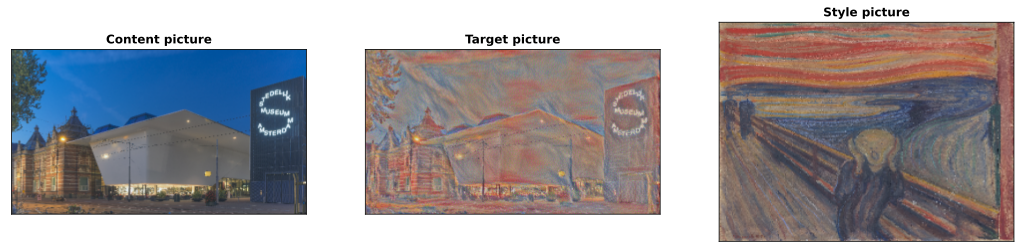

In [18]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()